In [1]:
# -*- coding: utf-8 -*-
# Licensed under a 3-clause BSD style license - see LICENSE.rst
import logging
import os
import warnings
from collections import OrderedDict
from multiprocessing import Pool

import astropy
from astropy.table import Table, hstack
import astropy.units as u
from astropy.io import ascii
from astropy.constants import alpha, c, e, hbar, m_e, m_p, sigma_sb
from astropy.utils.data import get_pkg_data_filename
from astropy.cosmology import WMAP9 as cosmo

import numpy as np
import matplotlib.pyplot as plt

from Validator import (
    validate_array,
    validate_physical_type,
    validate_scalar,
)
#from .model_utils import memoize
from Utils import trapz_loglog

import Models
import Radiative
import grbloader
from GRBmodel import GRBModel1
from GRBmodelstr import GRBModel_topstruc
from Models import EblAbsorptionModel

from astropy.units import def_physical_type

try:
    #def_physical_type(u.Unit("1 / eV"), "differential energy")
    def_physical_type(u.erg / u.cm**2 / u.s, "flux")
    def_physical_type(u.Unit("1/(s cm2 erg)"), "differential flux")
    def_physical_type(u.Unit("1/(s erg)"), "differential power")
    def_physical_type(u.Unit("1/TeV"), "differential energy")
    def_physical_type(u.Unit("1/cm3"), "number density")
    def_physical_type(u.Unit("1/(eV cm3)"), "differential number density")

except ValueError:
    print("New quantities already defined")

New quantities already defined


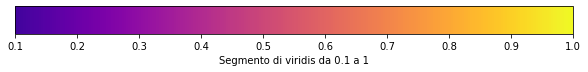

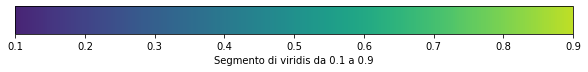

In [ ]:
from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

vmin = 0.1
vmax = 1
original_cmap = plt.cm.plasma

cmap1 = truncate_colormap(original_cmap, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap1,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()

vmin = 0.1
vmax = 0.9
original_cmap2 = plt.cm.viridis

cmap2 = truncate_colormap(original_cmap2, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap2,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()
print("ciao")

In [7]:
############################################### PARAMETERS ####################################

Eiso = 8e51  # erg
density = 0.01 #0.5  # cm-3
redshift = 0.1
tstart = 68   # s
tstop = 110   # s

#-----list of parameters of a electron distribution (log10) ------

eta_e=-1.44
Ebreak=-1.62
Index2=3.3
Ec=1.32  # cutoff energy in TeV
B=0.25

#################################################################################################

In [ ]:
#multi_Eiso=np.logspace(49,52,10)
multi_Eiso = [8e51]

# Plot
plt.figure(figsize=(12,8))
plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))
color=0

for Eiso in multi_Eiso:
    #---------------------------------- ENERGY GRID ----------------------------------------------
    emin=1e-3
    emax=1e16
    bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
    ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV
    #----------------------------------------------------------------------------------------------
    
    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)
    
    
    

    model= grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)


    SSC=model[0]
    #SSC_no_abs=model[1]

    SSC_approx= grb.synch_comp_approx + grb.ic_comp_approx

    SSC_val = np.clip(SSC_approx.value, 1e-30, 1e50)  # limiti ragionevoli
    ymax=np.max(SSC_val)
    ymin=np.min(SSC_val)
    
    ordine = int(np.ceil(np.log10(ymax)))
    ymax = 10**ordine
    ymin = 10**(ordine - 6)
    
    #grb.plot_sed(1e-3,1e16,6)
    spectrum_energy=np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV

    
    plt.loglog(ener,grb.ic_comp,lw=1.5,ls='--',c="black")
    plt.loglog(ener,grb.synch_comp,lw=1.5,ls=':',c="gray")

    plt.loglog(ener,SSC,lw=2,label=f'SSC isotropic - Eiso= {"{:.1e}".format(Eiso)}',c="darkblue")
    #plt.loglog(spectrum_energy,SSC_no_abs,lw=2,label=f'SSC isotropic - Eiso= {"{:.1e}".format(Eiso)}',c="blue")


    plt.loglog(ener,SSC_approx,lw=2,label=f'SSC isotropic approx - Eiso= {"{:.1e}".format(Eiso)}',c="orange")
    
    """n_shells = grb_struc.shells

    for i in range(n_shells):  # o range(0,4)
        shell_flux = (grb_struc.synch_comp_approx[i,:] + grb_struc.ic_comp_approx[i,:])
        plt.loglog(spectrum_energy, shell_flux, lw=2, ls='--', color=cmap2(i / n_shells), label=f'shell{i} total')
        #plt.loglog(spectrum_energy, grb_struc.synch_comp_approx[i,:], lw=2, ls='--', color=cmap2(i / n_shells), label=f'shell{i}')
        #plt.loglog(spectrum_energy, grb_struc.ic_comp_approx[i,:], lw=1.5, ls=':', color=cmap2(i / n_shells),label=f'shell{i}')"""
        


plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(model[0].unit.to_string('latex_inline')),fontsize=15)

plt.ylim(ymin, ymax)
#plt.ylim(1e-14, 1e-10)
plt.xlim(1e-3,5e16)
plt.tight_layout()
plt.legend(loc='lower left')


plt.title(f"SSC test",fontsize=15)
print("")
plt.grid(True, which="both", linestyle="--", alpha=0.6)

#plt.savefig("/media/tobiazenbook/PortableSSD/JOB/Projects/GRB-modelling/Plots-April30/plot1", format="jpg", dpi=300)
plt.show()

In [ ]:
grb.plot_sed(1e-3,1e16,order_bottom=6)

In [5]:
#multi_Eiso=np.logspace(49,52,10)
multi_Eiso = [8e51]

#---------------------------------- ENERGY GRID ----------------------------------------------
emin=1e-3
emax=1e16
bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV
#----------------------------------------------------------------------------------------------

# Plot
plt.figure(figsize=(12,8))
plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))
color=0

for Eiso in multi_Eiso:
    
    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)
    
    
    grb_struc= GRBModel_topstruc(eiso_zero=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],
                        energy_profile='powerlaw',shells=4,
                        scenario='ISM',cooling_constrain=False,data=ener)               
    

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 103.39689877485736
 ------------------ Ending GRB initialization ------------------

the code can be used only for computation of theoretical curves

 ------------------ Starting structured GRB initialization ------------------
Theta limits (deg): [ 0.  5. 10. 15. 20.]
Gamma: [93.38448011 84.59663665 74.21832564 65.51498069]
 ------------------ Ending structured GRB initialization ------------------



<Figure size 864x576 with 0 Axes>

the code can be used only for computation of theoretical curves

 ------------------ Starting GRB initialization ------------------
Gamma 103.39689877485736
 ------------------ Ending GRB initialization ------------------

the code can be used only for computation of theoretical curves

 ------------------ Starting structured GRB initialization ------------------
Theta limits (deg): [ 0.          3.33333333  6.66666667 10.         13.33333333 16.66666667
 20.        ]
Gamma: [94.1671576  89.61233146 82.82427122 75.86216979 69.6126891  64.25796471]
 ------------------ Ending structured GRB initialization ------------------


-------------------- Starting GRB computation --------------------
Theta max (deg): 2.216537640566633  = 4\Gamma
Gamma factor ISO : 103.39689877485736
 Doppler factor(theta) [206.7889617  172.68148432 115.52048342  74.44802901  49.70656395
  34.82623565  25.49733667  19.36660865  15.16065578  12.16628778]
-------------------- ending GRB computation -----------------

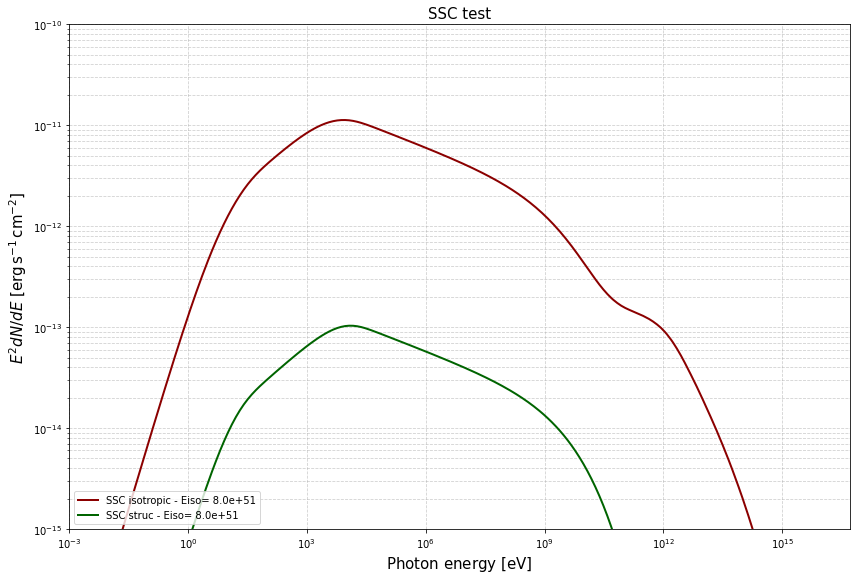

In [21]:
#multi_Eiso=np.logspace(49,52,10)
multi_Eiso = [8e51]

# Plot
plt.figure(figsize=(12,8))
plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')

#plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0.9))

for Eiso in multi_Eiso:   
    
    #---------------------------------- ENERGY GRID ----------------------------------------------
    emin=1e-3
    emax=1e16
    bins = int(np.log10(emax/emin) * 20.)  # use 20 bins per decade
    ener = Table([np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV], names=['energy'])  # energy in eV
    #----------------------------------------------------------------------------------------------
    
    grb = GRBModel1(eiso=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],scenario='ISM',cooling_constrain=False,data=ener)
    
    
    grb_struc= GRBModel_topstruc(eiso_zero=Eiso, dens=density, tstart=tstart, tstop=tstop, redshift=redshift,
                        pars=[eta_e, Ebreak,Index2, Ec,  B],
                        labels=['log10(eta_e)', 'log10(Ebreak)', 'Index2', 'log10(Ec)', 'log10(B)'],
                        energy_profile='powerlaw',shells=6,
                        scenario='ISM',cooling_constrain=False,data=ener)               
    

    model= grb._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)
    model_str= grb_struc._SSCmodel_ind1fixed(pars=[eta_e, Ebreak,Index2, Ec, B],data=ener)

    SSC=model[0]
    #SSC_no_abs=model[1]
    SSC2=model_str[1]
    
    SSC2_approx= np.sum(grb_struc.synch_comp_approx, axis=0)+ np.sum(grb_struc.ic_comp_approx, axis=0)
    
    #SSC2=np.sum(grb_struc.synch_comp, axis=0)+ np.sum(grb_struc.ic_comp, axis=0)
    
    SSC2_val = np.clip(SSC.value, 1e-30, 1e50)  # limiti ragionevoli
    ymax=np.max(SSC2_val)
    ymin=np.min(SSC2_val)
    
    ordine = int(np.ceil(np.log10(ymax)))
    ymax = 10**(ordine)
    ymin = 10**(ordine - 5)
    
    #grb.plot_sed(1e-3,1e16,6)
    spectrum_energy=np.logspace(np.log10(emin), np.log10(emax), bins) * u.eV



    plt.loglog(spectrum_energy,SSC,lw=2,label=f'SSC isotropic - Eiso= {"{:.1e}".format(Eiso)}',c="darkred")
    #plt.loglog(spectrum_energy,SSC_no_abs,lw=2,label=f'SSC isotropic - Eiso= {"{:.1e}".format(Eiso)}',c="blue")

    plt.loglog(spectrum_energy,SSC2,lw=2,label=f'SSC struc - Eiso= {"{:.1e}".format(Eiso)}',c="darkgreen")
    
    #plt.loglog(spectrum_energy,SSC2_approx,lw=2,label=f'SSC struc approx - Eiso= {"{:.1e}".format(Eiso)}',c="darkblue")
    #plt.loglog(spectrum_energy,SSC_approx,lw=2,label=f'SSC isotropic approx - Eiso= {"{:.1e}".format(Eiso)}',c="orange")
    
    """n_shells = grb_struc.shells

    for i in range(n_shells):  # o range(0,4)
        shell_flux = (grb_struc.synch_comp_approx[i,:] + grb_struc.ic_comp_approx[i,:])
        plt.loglog(spectrum_energy, shell_flux, lw=2, ls='--', color=cmap2(i / n_shells), label=f'shell{i} total')
        #plt.loglog(spectrum_energy, grb_struc.synch_comp_approx[i,:], lw=2, ls='--', color=cmap2(i / n_shells), label=f'shell{i}')
        #plt.loglog(spectrum_energy, grb_struc.ic_comp_approx[i,:], lw=1.5, ls=':', color=cmap2(i / n_shells),label=f'shell{i}')"""
        


plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(model[0].unit.to_string('latex_inline')),fontsize=15)

plt.ylim(ymin, ymax)
#plt.ylim(1e-14, 1e-10)
plt.xlim(1e-3,5e16)
plt.tight_layout()
plt.legend(loc='lower left')


plt.title(f"SSC test",fontsize=15)
print("")
plt.grid(True, which="both", linestyle="--", alpha=0.6)

plt.savefig("/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/iso vs struc.jpg", format="jpg", dpi=300)
plt.show()

------------------------------------ Short Report---------------------------------------------------
Γ factor = [94.57863185 92.70584946 89.07080111 83.88372146 77.43443448 70.06557376]
η_B = 59.72914221303358
η_e = 0.03630780547701014
Shell Radius [1.90935530e+17 1.83448841e+17 1.69344624e+17 1.50195208e+17
 1.27987913e+17 1.04787641e+17] cm
---------------------------------------------------------------------------------------------------
Plot saved as: /media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/SED_Struc Jet 1.jpg.png/pdf


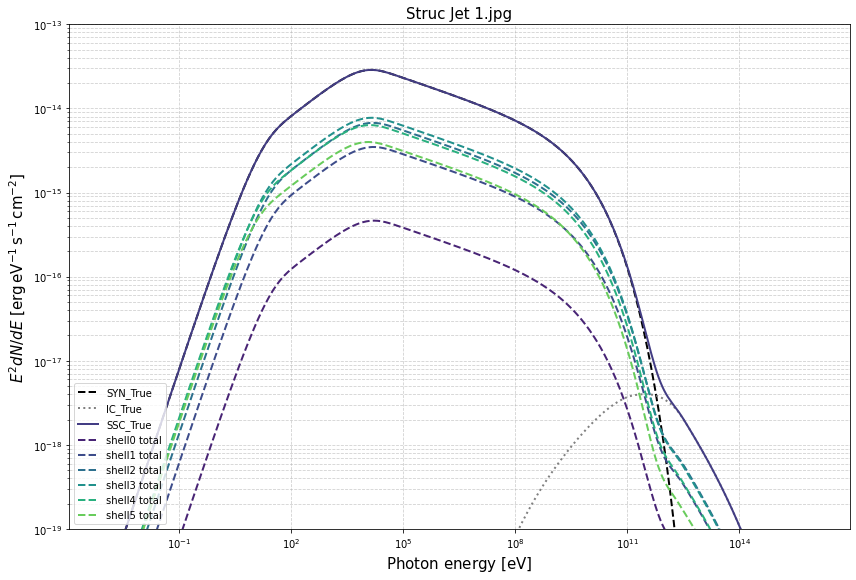

In [16]:
grb_struc.plot_sed(1e-3,1e16,order_bottom=6, plot_approx_spectrum=False,plot_true_spectrum=True,plot_approx_shells=False,plot_true_shells=True,
                   Save=True,path="/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/",Name="Struc Jet 1.jpg")

------------------------------------ Short Report---------------------------------------------------
Γ factor = [94.57863185 92.70584946 89.07080111 83.88372146 77.43443448 70.06557376]
η_B = 59.72914221303358
η_e = 0.03630780547701014
Shell Radius [1.90935530e+17 1.83448841e+17 1.69344624e+17 1.50195208e+17
 1.27987913e+17 1.04787641e+17] cm
---------------------------------------------------------------------------------------------------
Plot saved as: /media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/SED_Struc Jet 1 approx.jpg.png/pdf


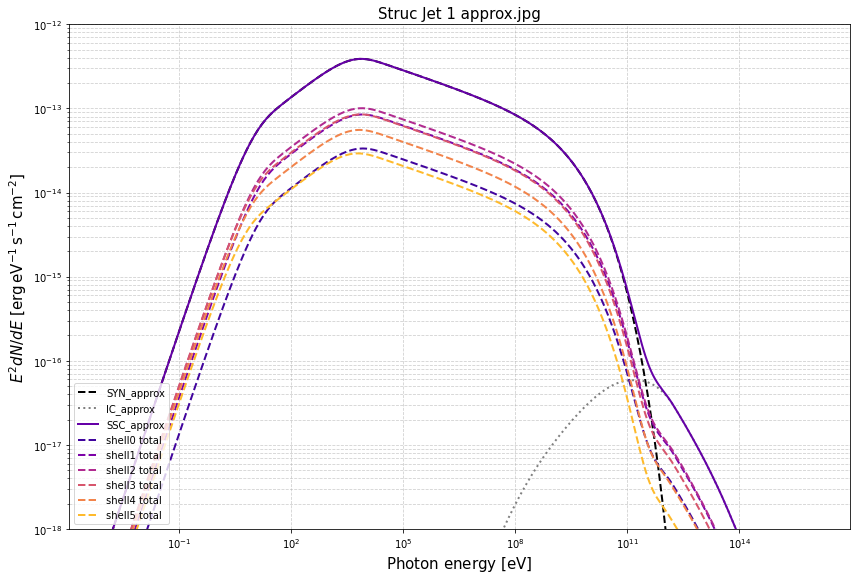

In [17]:
grb_struc.plot_sed(1e-3,1e16,order_bottom=6, plot_approx_spectrum=True,plot_true_spectrum=False,plot_approx_shells=True,plot_true_shells=False,
                   Save=True,path="/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/",Name="Struc Jet 1 approx.jpg")

In [ ]:
grb.plot_sed(1e-3,1e16,order_bottom=3)

In [ ]:


# Supponendo che:
# grb_struc.synch_comp_approx.shape = (n_shells, n_energy)
# grb_struc.ic_comp_approx.shape    = (n_shells, n_energy)
# model_wo_abs è già la somma di tutte le shell
# spectrum_energy è un Quantity astropy (array di energie)

n_shells = grb_struc.shells
spectrum_energy_val = spectrum_energy.value  # converto in array puro per matplotlib
cmap = plt.cm.viridis  # colormap per distinguere le shell

plt.figure(figsize=(12,8))

# Plot singole shell
for i in range(n_shells):
    shell_flux = (grb_struc.synch_comp_approx[i,:] + grb_struc.ic_comp_approx[i,:])  # converto Quantity in float
    plt.loglog(spectrum_energy_val, shell_flux, 
               lw=1.5, 
               ls='--', 
               color=cmap(i / n_shells), 
               label=f'Shell {i+1}')

# Plot totale
#plt.loglog(spectrum_energy_val, model_wo_abs.value, lw=2, color='black', label='Total')

plt.xlabel(f'Photon energy [{spectrum_energy.unit.to_string("latex_inline")}]', fontsize=15)
#plt.ylabel(f'$E^2 dN/dE$ [{model_wo_abs.unit.to_string("latex_inline")}]', fontsize=15)
plt.xlim(1e-3, 5e16)
plt.ylim(1e-14, 1e-10)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(loc='lower left')
plt.title('SSC Flux per shell and Total', fontsize=15)
plt.tight_layout()
plt.show()


In [ ]:
grb.print_GRB_status()

grb_struc.print_GRB_status()



Plot saved as: /media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/SED_Struc Jet profile powerlaw.jpg.png/pdf


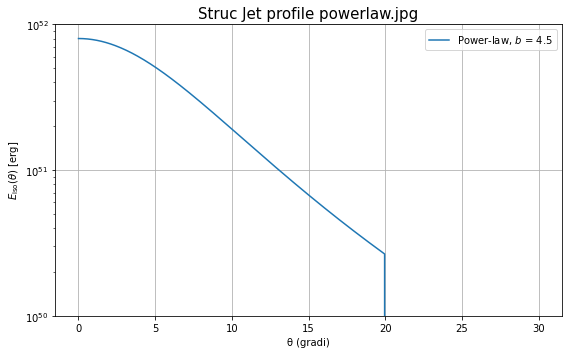

In [22]:
grb_struc.plot_jet_profile(bottom_order=2,Save=True,Name="Struc Jet profile powerlaw.jpg",
                           path="/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/")

Plot saved as: /media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/SED_Gamma_Radius isotropic gaussian.jpg .png/pdf


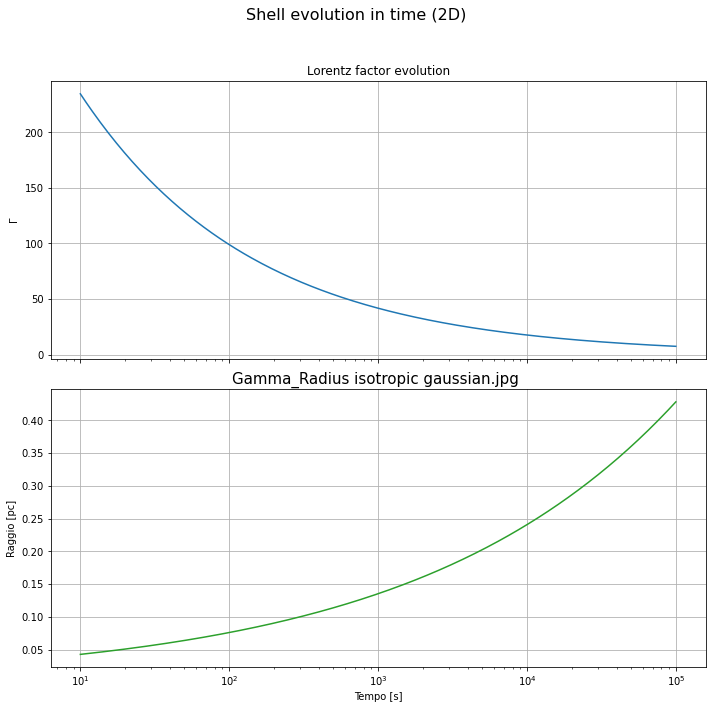

In [19]:
grb.plot_gamma_radius_vs_time(tmin=10, tmax=1e5, num=300, Save=True,
                               path="/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/", Name="Gamma_Radius isotropic gaussian.jpg ")

Plot saved as: /media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/Gamma_R_3D_struc powerlaw.jpg2.png/pdf


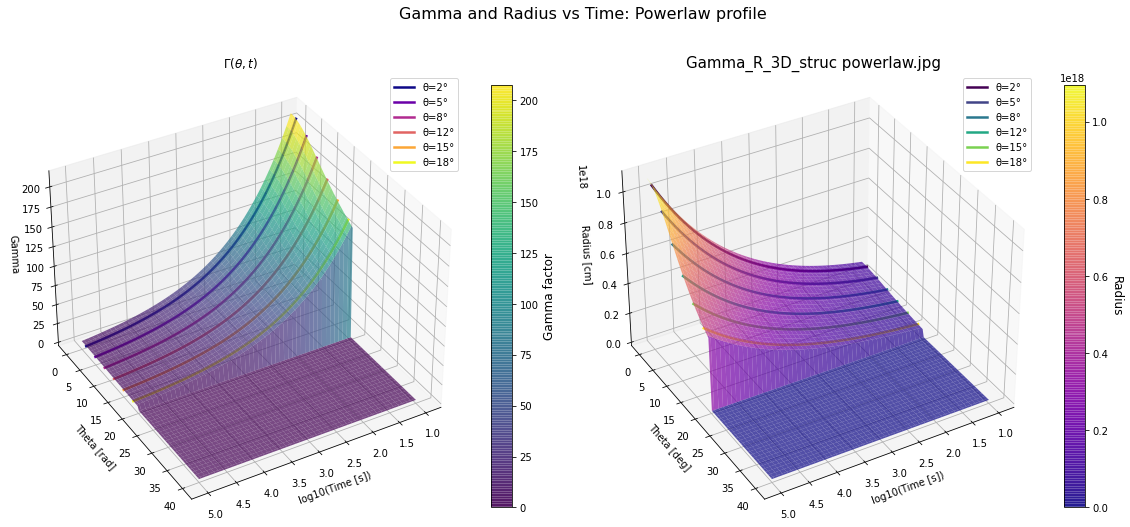

Plot saved as: /media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/Gamma_R_3D_struc powerlaw.jpg1.png/pdf


<Figure size 1152x576 with 0 Axes>

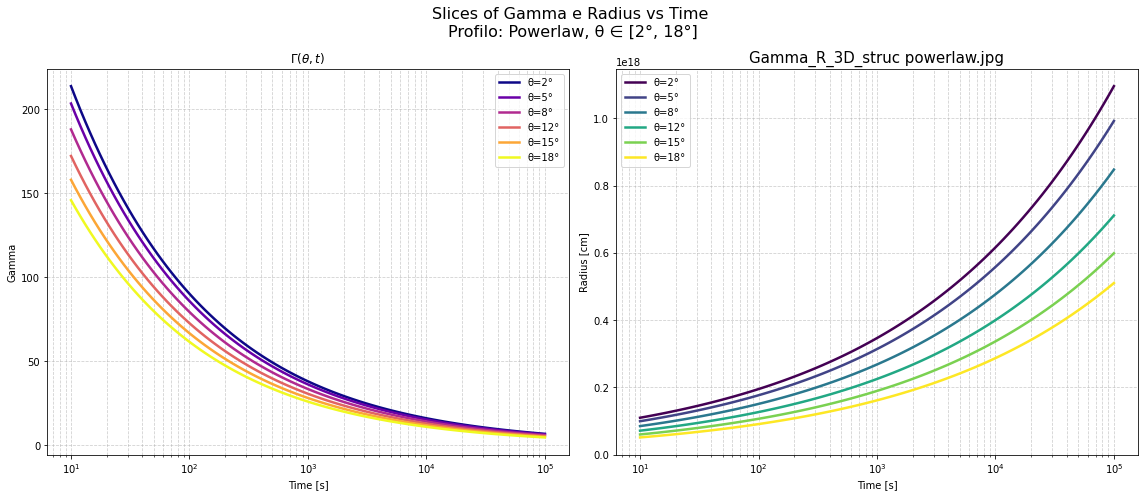

In [23]:
grb_struc.plot_gamma_R_3D_range(t_min=10, t_max=1e5, theta_min=0, theta_max=40,n_t=100, n_theta=100,slice=True,elevation=35,azimut=60,
                                Save=True,Name="Gamma_R_3D_struc powerlaw.jpg",path="/media/tobia-matcovich/PortableSSD/JOB/Projects/GRB-modelling/Plots-September15/")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri
Gamma = 100  # puoi provare con altri valori, tipo 10, 50, 300
beta = np.sqrt(1 - 1 / Gamma**2)

# Angoli da 0 a 90 gradi (in radianti)
theta = np.linspace(0, np.pi/8, 1000)

# Fattore di Doppler in funzione dell'angolo
delta = 1 / (Gamma * (1 - beta * np.cos(theta)))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.degrees(theta), delta, label=r"$\delta(\theta)$", color='crimson')
plt.axhline(Gamma, linestyle='--', color='gray', label=r"$\Gamma$ (costante)")
plt.xlabel(r"$\theta$ [gradi]")
plt.ylabel(r"Doppler factor")
plt.title(r"Confronto tra $\delta(\theta)$ e $\Gamma$ per $\Gamma={}$".format(Gamma))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri
Eiso_zero =   Eiso             # erg


# Angoli da 0 a 90 gradi
theta = np.linspace(0, 30, 500)

# Funzione con truncazione
def E_theta_gaussian(theta, Eiso_zero, thetacore, thetaw):
    E = np.zeros_like(theta)
    #inside = theta <= thetaw
    E = Eiso_zero * np.exp(-(theta**2) / (2 * thetacore**2))
    return E
# Modello power-law (senza troncamento)

def E_theta_powerlaw(theta, Eiso_zero, thetacore,thetaw,b):
    E = np.zeros_like(theta)
    #inside = theta <= thetaw
    #E[inside] =Eiso_zero * (1 + (theta[inside]**2) / (b * thetacore**2))**(-b/2)
    E =Eiso_zero * (1 + (theta**2) / (b * thetacore**2))**(-b/2)
    return E

# Calcolo e plot
E = E_theta_gaussian(theta, Eiso_zero, thetacore=4, thetaw=12)
E_powerlaw = E_theta_powerlaw(theta, Eiso_zero, thetacore=4,thetaw=20, b=4.5)

ymax=np.max(E)
ymin=np.min(E)
    
plt.figure(figsize=(8,5))
plt.plot(theta, E, label=r"Gaussiano troncato °" )
plt.plot(theta, E_powerlaw, label=fr"Power-law, $b$ = {4.5}")
#plt.axvline(thetaw_, color='gray', linestyle='--', label=r"Troncamento $\theta_w$")
plt.xlabel("θ (gradi)")
plt.ylabel(r"$E_{\mathrm{iso}}(\theta)$ [erg]")
plt.title("Profilo angolare dell'energia isotropica")
plt.yscale("log")
plt.ylim(1e49, 1e52)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Parametri del problema
Gamma = 100
beta = np.sqrt(1 - 1 / Gamma**2)
z = 0.5  # redshift
redf = 1 + z

# Fattore di Doppler
def doppler(theta_rad):
    return 1 / (Gamma * (1 - beta * np.cos(theta_rad)))

# SED arbitraria nel frame comovente (qui power-law)
def SED(E_com):
    return E_com**(-1.0)  # puoi cambiarlo con la tua funzione

# Integrando: δ(θ)^2 * SED(δ(θ) E_obs (1+z)) * sin(θ)
def integrand(theta_rad, E_obs):
    delta = doppler(theta_rad)
    E_com = delta * E_obs * redf
    return delta**2 * SED(E_com) * np.sin(theta_rad) * 2 * np.pi  # fattore 2π per integrazione su φ

# Range di energie osservate
energies_obs = np.logspace(-2, 2, 100)  # da 0.01 a 100 (unità arbitrarie)

# Calcolo flusso integrato vs on-axis
flux_integrated = []
flux_onaxis = []

for E in energies_obs:
    I, _ = quad(lambda theta: integrand(theta, E), 0, np.pi/2)
    delta0 = doppler(0)
    E_com0 = delta0 * E * redf
    F0 = delta0**2 * SED(E_com0)
    
    flux_integrated.append(I)
    flux_onaxis.append(F0)

# Plot
plt.figure(figsize=(8, 5))
plt.loglog(energies_obs, flux_integrated, label="Flusso integrato", color="crimson")
plt.loglog(energies_obs, flux_onaxis, '--', label="Flusso on-axis (δ ≈ Γ)", color="gray")
plt.xlabel("Energia osservata [unità arbitrarie]")
plt.ylabel("Flusso osservato [unità arbitrarie]")
plt.title(f"Confronto flusso integrato vs on-axis (Γ = {Gamma}, z = {z})")
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri
Gamma = 100
beta = np.sqrt(1 - 1 / Gamma**2)
z = 0.5
redf = 1 + z
E_obs = 1.0  # Energia osservata (unità arbitrarie)

# Doppler factor
def doppler(theta_rad):
    return 1 / (Gamma * (1 - beta * np.cos(theta_rad)))

# SED arbitraria
def SED(E_com):
    return E_com**(-1.0)  # power-law a indice 1

# Integrando dell'integrale angolare
def integrando(theta_rad):
    delta = doppler(theta_rad)
    E_com = delta * E_obs * redf
    return delta**2 * SED(E_com) * np.sin(theta_rad) * 2 * np.pi

# Angoli da 0 a 90 gradi
theta = np.linspace(0, np.pi / 2, 1000)
theta_deg = np.degrees(theta)
integrand_values = integrando(theta)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(theta_deg, integrand_values, color='crimson')
plt.xlabel(r"$\theta$ [gradi]")
plt.ylabel(r"Integrando $f(\theta)$")
plt.title(r"Contributo angolare al flusso osservato ($\Gamma = {}$)".format(Gamma))
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Parametri
Gamma = 100
beta = np.sqrt(1 - 1 / Gamma**2)
z = 0.5
redf = 1 + z
E_obs = 1.0  # Energia osservata (unità arbitrarie)

# Funzione Doppler
def doppler(theta_rad):
    return 1 / (Gamma * (1 - beta * np.cos(theta_rad)))

# SED nel frame comovente
def SED(E_com):
    return E_com**(-1.0)  # power-law (modificabile)

# Integrando
def integrando(theta_rad):
    delta = doppler(theta_rad)
    E_com = delta * E_obs * redf
    return delta**2 * SED(E_com) * np.sin(theta_rad) * 2 * np.pi

# Theta massimo per il cono ~ 1/Gamma
theta_max = 1 / Gamma

# Calcolo dell'integrale nel cono stretto
flux_cone, _ = quad(integrando, 0, theta_max)

# Flusso on-axis (senza integrazione)
delta0 = doppler(0)
E_com0 = delta0 * E_obs * redf
flux_onaxis = delta0**2 * SED(E_com0)

# Area angolare del cono stretto
dOmega_cone = 2 * np.pi * (1 - np.cos(theta_max))

# Valore "esteso" del flusso on-axis su quella area (modello semplificato)
flux_onaxis_scaled = flux_onaxis * dOmega_cone

# Print dei risultati
print(f"Flusso integrato nel cono (θ < 1/Γ):    {flux_cone:.4e}")
print(f"Flusso on-axis × area del cono:         {flux_onaxis_scaled:.4e}")
print(f"(Differenza relativa: {abs(flux_cone - flux_onaxis_scaled)/flux_cone:.2%})")

# Plot comparativo (barplot)
labels = ['Flusso integrato', 'On-axis × area']
values = [flux_cone, flux_onaxis_scaled]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['crimson', 'gray'])
plt.ylabel("Flusso osservato [unità arbitrarie]")
plt.title(f"Confronto tra approccio integrato e on-axis × area (Γ = {Gamma})")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Parametri fisici
Gamma = 100
beta = np.sqrt(1 - 1 / Gamma**2)
z = 0.5
redf = 1 + z
E_obs = 1.0  # energia osservata (unità arbitrarie)

# Doppler factor (funzione di theta in radianti)
def doppler(theta_rad):
    return 1 / (Gamma * (1 - beta * np.cos(theta_rad)))

# SED nel frame comovente (esempio power-law con indice -1)
def SED(E_com):
    return E_com**(-1.0)

# Integrando: delta^2 * SED(delta*E_obs*(1+z)) * sin(theta) * 2*pi
def integrando(theta_rad):
    delta = doppler(theta_rad)
    E_com = delta * E_obs * redf
    return delta**2 * SED(E_com) * np.sin(theta_rad) * 2 * np.pi

# Intervallo angolare da 0 a 90 gradi (in radianti)
theta = np.linspace(0, np.pi/2, 100000)

# Valori dell'integrando su griglia
f_theta = integrando(theta)

# Separazione core / wings a theta = 1/Gamma
theta_split = 1 / Gamma
split_idx = np.searchsorted(theta, theta_split)

# Integrazione numerica con trapz (integrazione numerica semplice e precisa)
flux_core = np.trapz(f_theta[:split_idx], theta[:split_idx])
flux_wings = np.trapz(f_theta[split_idx:], theta[split_idx:])
flux_total = flux_core + flux_wings

# Flusso approssimato on-axis:
delta_on_axis = doppler(0)
flux_on_axis_approx = delta_on_axis**2 * SED(delta_on_axis * E_obs * redf) * 2 * np.pi * (1 / Gamma)**2  # area ~ π θ^2 con θ=1/Gamma

# Percentuali
pct_core = 100 * flux_core / flux_total
pct_wings = 100 * flux_wings / flux_total

# Stampa risultati
print(f"Flusso totale:            {flux_total:.4e}")
print(f"Flusso (θ < 1/Γ):         {flux_core:.4e}  ({pct_core:.2f}%)")
print(f"Flusso (θ > 1/Γ):         {flux_wings:.4e}  ({pct_wings:.2f}%)")
print(f"Flusso approssimato on-axis: {flux_on_axis_approx:.4e}")

# Grafico a barre
labels = [r"$\theta < 1/\Gamma$", r"$\theta > 1/\Gamma$"]
values = [flux_core, flux_wings]

plt.figure(figsize=(6,4))
plt.bar(labels, values, color=['mediumseagreen', 'orange'])
plt.ylabel("Flusso osservato [unità arbitrarie]")
plt.title(f"Distribuzione angolare del flusso (Γ = {Gamma})")
plt.grid(axis='y', ls=':')
plt.tight_layout()
plt.show()

# Grafico integrando
plt.figure(figsize=(6,4))
plt.plot(np.degrees(theta), f_theta)
plt.yscale('log')
plt.xlabel(r"$\theta$ [gradi]")
plt.ylabel("Integrando")
plt.title("Profilo angolare del flusso")
plt.grid(True)
plt.tight_layout()
plt.show()

theta_max_vals = np.linspace(0.001, np.pi/2, 100)
flux_cumulative = []

for t_max in theta_max_vals:
    flux_cum = np.trapz(f_theta[theta <= t_max], theta[theta <= t_max])
    flux_cumulative.append(flux_cum)

plt.plot(np.degrees(theta_max_vals), flux_cumulative)
plt.xlabel(r"$\theta_{\max}$ [gradi]")
plt.ylabel("Flusso cumulativo integrato")
plt.title("Flusso cumulativo in funzione di $\theta_{max}$")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Parametri fisici
Gamma = 2
beta = np.sqrt(1 - 1 / Gamma**2)
z = 0.5
redf = 1 + z
E_obs = 1.0  # energia osservata (unità arbitrarie)

# Doppler factor
def doppler(theta):
    return 1 / (Gamma * (1 - beta * np.cos(theta)))

# SED nel frame comovente
def SED(E_com):
    return E_com**(-1.0)

# Metodo 1: On-axis * area angolare efficace
delta0 = doppler(0.0)
E_com_0 = delta0 * E_obs * redf
flux_density = delta0**2 * SED(E_com_0) * (1 + z)

# Area efficace del beaming cone (theta < 1/Gamma)
theta_max = 1 / Gamma
omega_eff = 2 * np.pi * (1 - np.cos(theta_max))  # ≈ pi / Gamma^2 per Gamma >> 1

F_onaxis = flux_density * omega_eff  # flusso integrato approssimato

# Metodo 2: Integrale corretto
theta = np.linspace(0, np.pi/2, 100000)
delta = doppler(theta)
E_com = delta * E_obs * redf
integrando = delta**2 * SED(E_com) * np.sin(theta) * 2 * np.pi
F_integrale = trapz(integrando, theta)

# Confronto
print("Confronto flussi osservati:")
print(f"➤ Metodo approssimato (on-axis × area): {F_onaxis:.4e}")
print(f"➤ Metodo integrale corretto:            {F_integrale:.4e}")
print(f"➤ Rapporto (approx / integrale):        {F_onaxis / F_integrale:.4f}")

# Grafico
labels = ['On-axis × area', 'Integrale corretto']
values = [F_onaxis, F_integrale]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['royalblue', 'crimson'])
plt.ylabel("Flusso osservato [unità arbitrarie]")
plt.title(f"Confronto flusso osservato (Γ = {Gamma})")
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Parametri fissi
z = 0.5
redf = 1 + z
E_obs = 1.0  # energia osservata arbitraria

# SED comovente (power-law modificabile)
def SED(E_com):
    return E_com**(-1.0)

# Doppler factor
def doppler(theta, Gamma):
    beta = np.sqrt(1 - 1 / Gamma**2)
    return 1 / (Gamma * (1 - beta * np.cos(theta)))

# Calcolo dei flussi per una gamma data
def compute_fluxes(Gamma):
    beta = np.sqrt(1 - 1 / Gamma**2)

    # Metodo approssimato (on-axis con area efficace)
    delta0 = doppler(0.0, Gamma)
    E_com_0 = delta0 * E_obs * redf
    flux_density = delta0**2 * SED(E_com_0) * (1 + z)
    theta_max = 1 / Gamma
    omega_eff = 2 * np.pi * (1 - np.cos(theta_max))
    F_onaxis = flux_density * omega_eff

    # Metodo integrale
    theta = np.linspace(0, np.pi/2, 10000)
    delta = doppler(theta, Gamma)
    E_com = delta * E_obs * redf
    integrando = delta**2 * SED(E_com) * np.sin(theta) * 2 * np.pi
    F_integrale = trapz(integrando, theta)

    return F_onaxis, F_integrale

# Gamma da testare
gamma_vals = np.logspace(np.log10(5), np.log10(500), 50)
ratios = []

for G in gamma_vals:
    F_approx, F_exact = compute_fluxes(G)
    ratios.append(F_approx / F_exact)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(gamma_vals, ratios, lw=2, color='darkblue')
plt.axhline(1.0, ls='--', color='gray', label='Parità')
plt.xscale('log')
plt.xlabel(r"$\Gamma$")
plt.ylabel(r"Flusso approssimato / flusso integrale")
plt.title("Validità dell'approssimazione on-axis vs integrale")
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# === Parametri fisici ===
Gamma =  300
beta = np.sqrt(1 - 1 / Gamma**2)
z = 0.5
redf = 1 + z
E_obs = 1.0  # energia osservata arbitraria

# === Doppler factor ===
def doppler(theta):
    return 1 / (Gamma * (1 - beta * np.cos(theta)))

# === SED comovente (es. power-law) ===
def SED(E_com):
    return E_com**(-1.0)

# === Metodo 1: Flusso approssimato on-axis × area effettiva ===
delta0 = doppler(0.0)
E_com_0 = delta0 * E_obs * redf
flux_density = delta0**2 * SED(E_com_0) * (1 + z)
theta_max = 1 / Gamma
omega_eff = 2 * np.pi * (1 - np.cos(theta_max))
F_onaxis = flux_density * omega_eff

# === Metodo 2: Flusso integrato solo nel cono relativistico ===
theta_beam = np.linspace(0, theta_max, 10000)
delta_beam = doppler(theta_beam)
E_com_beam = delta_beam * E_obs * redf
integrando_beam = delta_beam**2 * SED(E_com_beam) * np.sin(theta_beam) * 2 * np.pi
F_beam_integrated = trapz(integrando_beam, theta_beam)

# === Metodo 3: Flusso integrato su tutta la metà sfera ===
theta_full = np.linspace(0, np.pi/2, 10000)
delta_full = doppler(theta_full)
E_com_full = delta_full * E_obs * redf
integrando_full = delta_full**2 * SED(E_com_full) * np.sin(theta_full) * 2 * np.pi
F_total = trapz(integrando_full, theta_full)

# === Risultati ===
print(f"Flusso approssimato (on-axis × area):   {F_onaxis:.4e}")
print(f"Flusso integrato (θ < 1/Γ):             {F_beam_integrated:.4e}")
print(f"Flusso integrato totale (θ < π/2):      {F_total:.4e}")
print(f"\nRapporto appross / beam:               {F_onaxis / F_beam_integrated:.4f}")
print(f"Rapporto appross / totale:              {F_onaxis / F_total:.4f}")
print(f"Rapporto beam / totale:                 {F_beam_integrated / F_total:.4f}")

# === Grafico ===
labels = [
    "On-axis × area",
    "Integrale (θ < 1/Γ)",
    "Integrale (θ < π/2)"
]
values = [F_onaxis, F_beam_integrated, F_total]

plt.figure(figsize=(7, 4))
plt.bar(labels, values, color=['royalblue', 'mediumseagreen', 'orangered'])
plt.ylabel("Flusso osservato [unità arbitrarie]")
plt.title(f"Confronto dei flussi osservati (Γ = {Gamma})")
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

z = 0.5
redf = 1 + z
E_obs = 1.0  # energia osservata arbitraria

def doppler(theta, Gamma):
    beta = np.sqrt(1 - 1 / Gamma**2)
    return 1 / (Gamma * (1 - beta * np.cos(theta)))

def SED(E_com):
    return E_com**(-1.0)

Gamma_values = np.logspace(0.5, 3, 30)  # da ~3 a 1000

F_onaxis_arr = []
F_beam_int_arr = []
F_total_arr = []

for Gamma in Gamma_values:
    delta0 = doppler(0.0, Gamma)
    E_com_0 = delta0 * E_obs * redf
    flux_density = delta0**2 * SED(E_com_0) * (1 + z)
    theta_max = 1 / Gamma
    omega_eff = 2 * np.pi * (1 - np.cos(theta_max))
    F_onaxis = flux_density * omega_eff

    theta_beam = np.linspace(0, theta_max, 10000)
    delta_beam = doppler(theta_beam, Gamma)
    E_com_beam = delta_beam * E_obs * redf
    integrando_beam = delta_beam**2 * SED(E_com_beam) * np.sin(theta_beam) * 2 * np.pi
    F_beam_integrated = trapz(integrando_beam, theta_beam)

    theta_full = np.linspace(0, np.pi/2, 10000)
    delta_full = doppler(theta_full, Gamma)
    E_com_full = delta_full * E_obs * redf
    integrando_full = delta_full**2 * SED(E_com_full) * np.sin(theta_full) * 2 * np.pi
    F_total = trapz(integrando_full, theta_full)

    F_onaxis_arr.append(F_onaxis)
    F_beam_int_arr.append(F_beam_integrated)
    F_total_arr.append(F_total)

# Plot valori assoluti
plt.figure(figsize=(10,6))
plt.loglog(Gamma_values, F_onaxis_arr, label="On-axis × area")
plt.loglog(Gamma_values, F_beam_int_arr, label="Integrale (θ < 1/Γ)")
plt.loglog(Gamma_values, F_total_arr, label="Integrale (θ < π/2)")
plt.xlabel(r"$\Gamma$")
plt.ylabel("Flusso osservato [unità arbitrarie]")
plt.title("Flusso osservato vs Lorentz factor Γ")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# Plot rapporti
plt.figure(figsize=(10,6))
plt.semilogx(Gamma_values, np.array(F_onaxis_arr)/np.array(F_beam_int_arr), label="(On-axis × area) / (θ < 1/Γ)")
plt.semilogx(Gamma_values, np.array(F_onaxis_arr)/np.array(F_total_arr), label="(On-axis × area) / (θ < π/2)")
plt.semilogx(Gamma_values, np.array(F_beam_int_arr)/np.array(F_total_arr), label="(θ < 1/Γ) / (θ < π/2)")
plt.xlabel(r"$\Gamma$")
plt.ylabel("Rapporto flussi")
plt.title("Rapporti tra i flussi osservati")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

z = 0.5
redf = 1 + z
E_obs = 1.0  # energia osservata

def doppler(theta, Gamma):
    beta = np.sqrt(1 - 1 / Gamma**2)
    return 1 / (Gamma * (1 - beta * np.cos(theta)))

def SED(E_com):
    return E_com**(-1.0)

Gamma = 100

# On-axis doppler e flusso approssimato
delta0 = doppler(0, Gamma)
E_com_0 = E_obs * redf / delta0  # <-- qui la correzione fondamentale
flux_density = delta0**2 * SED(E_com_0) * redf
theta_max = 1 / Gamma
omega_eff = 2 * np.pi * (1 - np.cos(theta_max))
F_onaxis = flux_density * omega_eff

# Integrazione core θ<1/Γ
theta_core = np.linspace(0, theta_max, 10000)
delta_core = doppler(theta_core, Gamma)
E_com_core = E_obs * redf / delta_core  # <-- correzione anche qui
integrando_core = delta_core**2 * SED(E_com_core) * np.sin(theta_core) * 2 * np.pi * redf
F_core = trapz(integrando_core, theta_core)

# Integrazione totale θ<π/2
theta_full = np.linspace(0, np.pi/2, 10000)
delta_full = doppler(theta_full, Gamma)
E_com_full = E_obs * redf / delta_full
integrando_full = delta_full**2 * SED(E_com_full) * np.sin(theta_full) * 2 * np.pi * redf
F_full = trapz(integrando_full, theta_full)

print(f"Flusso approssimato on-axis × area: {F_onaxis:.4e}")
print(f"Flusso integrale core (θ < 1/Γ):    {F_core:.4e}")
print(f"Flusso integrale totale (θ < π/2):  {F_full:.4e}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Parametri fissi
z = 0.5
redf = 1 + z
E_obs = 1.0  # energia osservata arbitraria

def doppler(theta_rad, Gamma):
    beta = np.sqrt(1 - 1 / Gamma**2)
    return 1 / (Gamma * (1 - beta * np.cos(theta_rad)))

def SED(E_com):
    return E_com**(-1.0)  # power law semplice

def integrando(theta_rad, Gamma):
    delta = doppler(theta_rad, Gamma)
    E_com = E_obs * delta * redf
    return delta**2 * SED(E_com) * np.sin(theta_rad) * 2 * np.pi

def flusso_integrato(Gamma):
    theta_split = 1 / Gamma
    # flusso core
    flux_core, _ = quad(integrando, 0, theta_split, args=(Gamma,), limit=1000)
    # flusso wings
    flux_wings, _ = quad(integrando, theta_split, np.pi/2, args=(Gamma,), limit=1000)
    flux_total = flux_core + flux_wings
    # flusso approssimato on-axis × area del core
    flux_approx = integrando(0, Gamma) * 2 * np.pi * (1 / Gamma)**2
    return flux_approx, flux_core, flux_total

# 1) Variazione flussi con Gamma
Gamma_vals = np.linspace(10, 500, 50)
flux_approx_arr = []
flux_core_arr = []
flux_total_arr = []

for G in Gamma_vals:
    f_approx, f_core, f_tot = flusso_integrato(G)
    flux_approx_arr.append(f_approx)
    flux_core_arr.append(f_core)
    flux_total_arr.append(f_tot)

plt.figure(figsize=(8,5))
plt.plot(Gamma_vals, flux_approx_arr, label='Approssimato on-axis × area core')
plt.plot(Gamma_vals, flux_core_arr, label='Flusso integrale core ($\\theta < 1/\\Gamma$)')
plt.plot(Gamma_vals, flux_total_arr, label='Flusso integrale totale ($\\theta < \\pi/2$)')
plt.xlabel('Lorentz factor $\\Gamma$')
plt.ylabel('Flusso osservato [unità arbitrarie]')
plt.title('Variazione del flusso osservato con $\\Gamma$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Profilo integrando in funzione di theta per Gamma fisso
Gamma_fixed = 100
theta_plot = np.linspace(0, np.pi/2, 300)
integrando_vals = [integrando(th, Gamma_fixed) for th in theta_plot]

plt.figure(figsize=(7,4))
plt.plot(np.degrees(theta_plot), integrando_vals)
plt.yscale('log')
plt.xlabel(r'$\theta$ [gradi]')
plt.ylabel('Integrando (contributo angolare al flusso)')
plt.title(f'Profilo angolare del flusso per $\\Gamma = {Gamma_fixed}$')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Rapporto tra flussi al variare di Gamma
ratios_core = np.array(flux_approx_arr) / np.array(flux_core_arr)
ratios_total = np.array(flux_approx_arr) / np.array(flux_total_arr)

plt.figure(figsize=(8,5))
plt.plot(Gamma_vals, ratios_core, label=r'Approssimato / Core integrale')
plt.plot(Gamma_vals, ratios_total, label=r'Approssimato / Totale integrale')
plt.axhline(1, color='k', ls='--', alpha=0.7)
plt.xlabel('Lorentz factor $\\Gamma$')
plt.ylabel('Rapporto flussi')
plt.title('Rapporto flussi approssimato vs integrale')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
